In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import json
import pickle

# Load Bengaluru House Data

In [2]:
df = pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

In [4]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


# Dropping Columns

In [5]:
df.drop(['area_type','society','balcony','availability'],axis=1, inplace=True)
df.shape

(13320, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13319 non-null  object 
 1   size        13304 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13247 non-null  float64
 4   price       13320 non-null  float64
dtypes: float64(2), object(3)
memory usage: 520.4+ KB


# Data Cleaning: Handling NA values

In [7]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
df.shape

(13246, 5)

# Feature Engineering

In [10]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

* Creating new column and store only BHK number

In [11]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [12]:
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


* Exploring total_sqft feature

In [13]:
# method checks the vaue is float or not. 
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [14]:
df[~df['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


* Above above shows that total_sqft have be a range. For such values, we can just take average

In [15]:
def convert_range_to_single_value(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [16]:
df['total_sqft'] = df['total_sqft'].apply(convert_range_to_single_value)

In [17]:
df.isnull().sum()

location       0
size           0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

In [18]:
df.dropna(inplace=True)
df.shape

(13200, 6)

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [19]:
df['sqft_price'] = df['price']*100000/df['total_sqft']
df.head()

,location,size,total_sqft,bath,price,bhk,sqft_price
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [20]:
df.describe()

,total_sqft,bath,price,bhk,sqft_price
count,13200.000000,13200.000000,13200.000000,13200.000000,1.320000e+04
mean,1555.302783,2.691136,112.276178,2.800833,7.920759e+03
std,1237.323445,1.338915,149.175995,1.292843,1.067272e+05
min,1.000000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.000000,2.000000,50.000000,2.000000,4.267701e+03
50%,1275.000000,2.000000,71.850000,3.000000,5.438331e+03
75%,1672.000000,3.000000,120.000000,3.000000,7.317073e+03
max,52272.000000,40.000000,3600.000000,43.000000,1.200000e+07


# Feature Engineering - Category columns

In [21]:
df['location'] = df['location'].apply(lambda x: x.strip())
locations = df['location'].value_counts(ascending=False)

In [22]:
locations.values.sum()

13200

In [23]:
len(locations[locations>10])

240

In [24]:
len(locations)

1287

<h2 style="color:blue">Dimensionality Reduction</h2>

* Any location having less than 10 data points should be tagged as "other" location.

In [25]:
locations_less_than_10 = locations[locations<=10]
locations_less_than_10

location
BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: count, Length: 1047, dtype: int64

In [26]:
len(df['location'].unique())

1287

In [27]:
df['location'] = df['location'].apply(lambda x: 'other' if x in locations_less_than_10 else x)
len(df.location.unique())

241

In [28]:
df[df['location'] == "other"]

,location,size,total_sqft,bath,price,bhk,sqft_price
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804
18,other,3 BHK,2770.0,4.0,290.00,3,10469.314079
19,other,2 BHK,1100.0,2.0,48.00,2,4363.636364
25,other,3 BHK,1250.0,3.0,56.00,3,4480.000000
42,other,1 BHK,600.0,1.0,38.00,1,6333.333333
...,...,...,...,...,...,...,...
13291,other,1 Bedroom,812.0,1.0,26.00,1,3201.970443
13292,other,3 BHK,1440.0,2.0,63.93,3,4439.583333
13302,other,2 BHK,1075.0,2.0,48.00,2,4465.116279
13306,other,4 Bedroom,1200.0,5.0,325.00,4,27083.333333


# Outlier Removal

* Checking size per bhk less than 300

In [29]:
df[df.total_sqft/df.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,sqft_price
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [30]:
df.shape

(13200, 7)

In [31]:
df = df[~(df.total_sqft/df.bhk<300)]
df.shape

(12456, 7)

# Outlier Removal: Using Standard Deviation and Mean

In [32]:
df['sqft_price'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: sqft_price, dtype: float64

* this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [33]:
def remove_sqft_price_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf['sqft_price'])
        st = np.std(subdf['sqft_price'])
        reduced_df = subdf[(subdf.sqft_price>(m-st)) & (subdf.sqft_price<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df = remove_sqft_price_outliers(df)
df.shape

(10242, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [34]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.sqft_price),
                'std': np.std(bhk_df.sqft_price),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.sqft_price<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df = remove_bhk_outliers(df)
# df8 = df7.copy()
df.shape

(7317, 7)

Text(0, 0.5, 'Count')

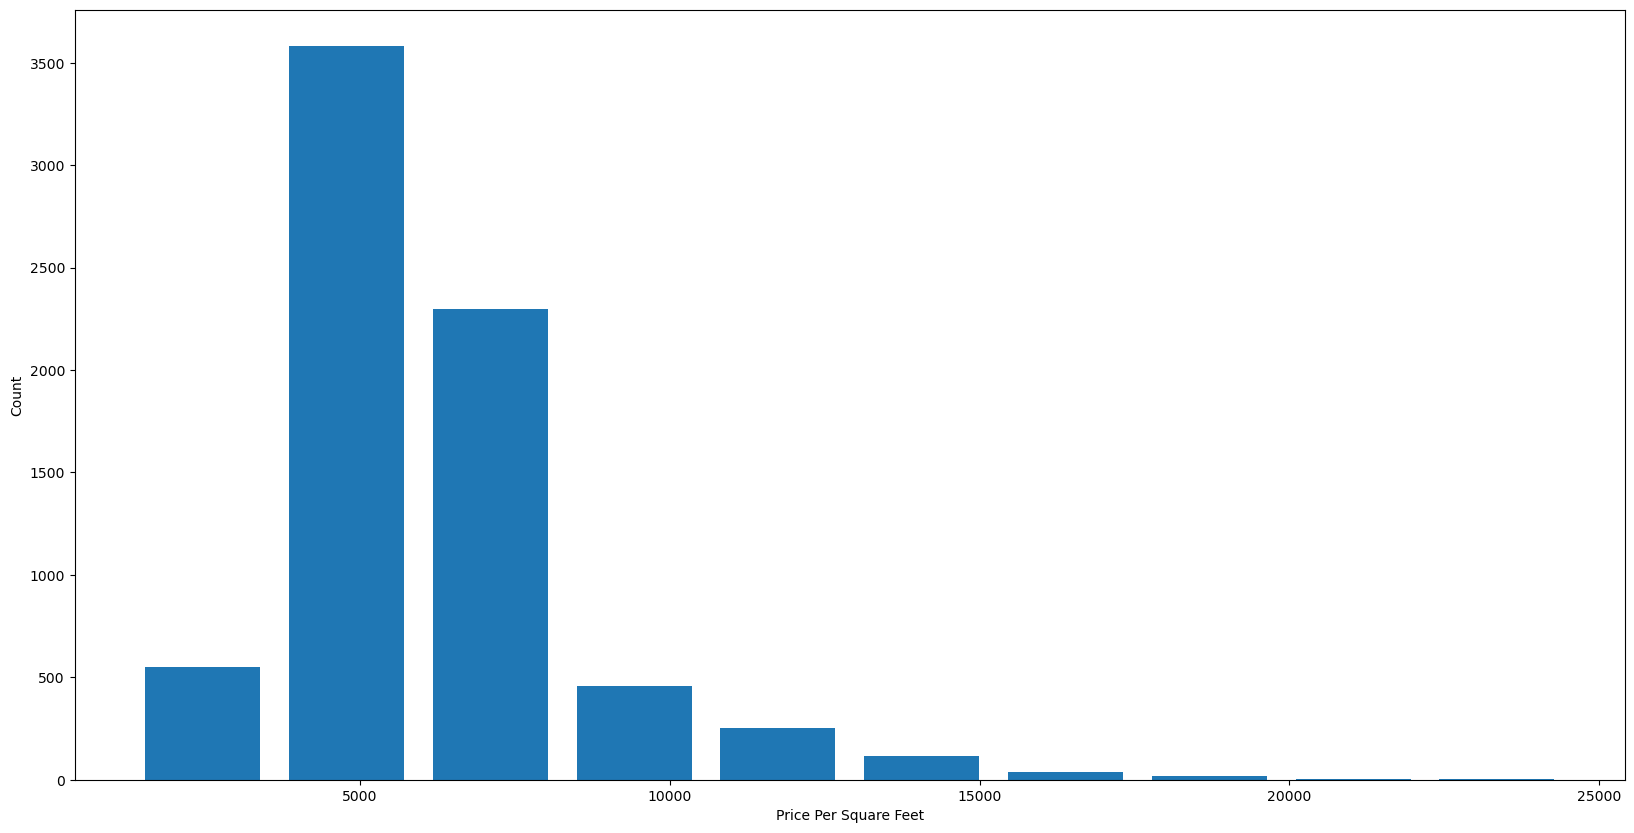

In [35]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df['sqft_price'],rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [36]:
df.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

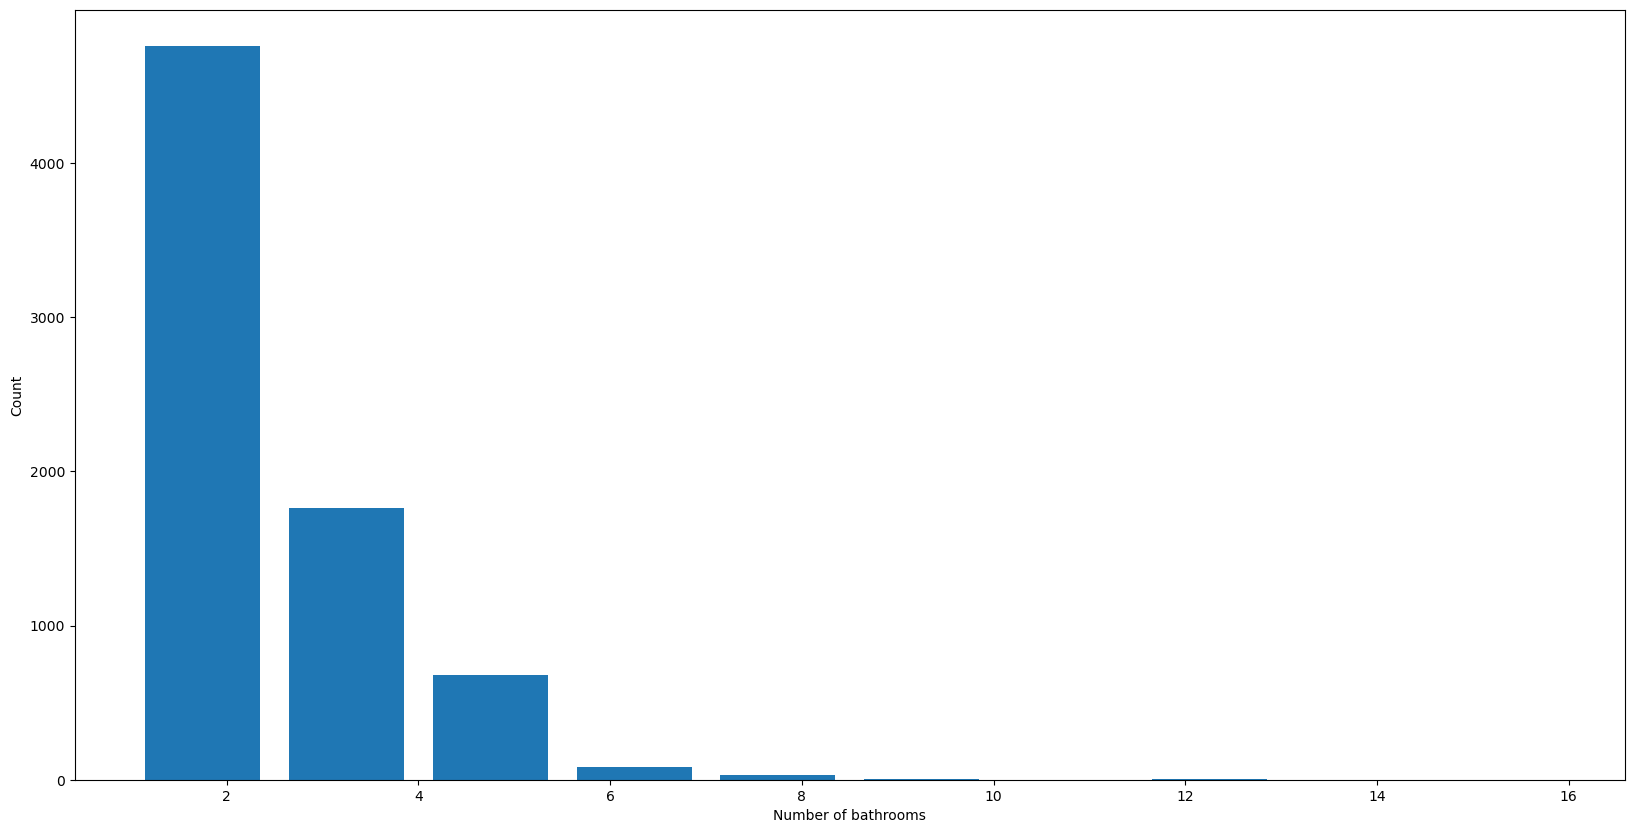

In [37]:
plt.hist(df.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [38]:
df[df.bath>10]

,location,size,total_sqft,bath,price,bhk,sqft_price
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


* It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [39]:
df[df.bath>df.bhk+2]

,location,size,total_sqft,bath,price,bhk,sqft_price
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


* Remove data which bathrooms have more than bhk of 2

In [40]:
df = df[df.bath<df.bhk+2]
df.shape

(7239, 7)

In [41]:
df.head()

,location,size,total_sqft,bath,price,bhk,sqft_price
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [42]:
df.drop(['size','sqft_price'],axis=1, inplace=True)
df.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [43]:
location_dummies = pd.get_dummies(df['location']).astype(int)
location_dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df = pd.concat([df,location_dummies.drop('other',axis=1)],axis=1)
df.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df = df.drop('location',axis=1)
df.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Building

In [46]:
df.shape

(7239, 244)

In [47]:
X = df.drop(['price'],axis=1)
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
X.shape

(7239, 243)

In [49]:
y = df['price']
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [50]:
len(y)

7239

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [52]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
lr_model.score(X_test,y_test)

0.7971924202569198

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [53]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

* We can see that in 5 iterations we get a score above 80% all the time. Test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [54]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

C:\Users\SivaKrushnaPandranki\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\SivaKrushnaPandranki\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\SivaKrushnaPandranki\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\SivaKrushnaPandranki\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_cons

,model,best_score,best_params
0,linear_regression,0.847796,{}
1,lasso,0.726738,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.694981,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


* Based on above results, we can say that LinearRegression gives the best score. 

<h2 style='color:blue'>Test the model for few properties</h2>

In [55]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_model.predict([x])[0]

In [56]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

C:\Users\SivaKrushnaPandranki\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


97.2106315989659

In [57]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Users\SivaKrushnaPandranki\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


101.59047425986464

In [58]:
predict_price('Indira Nagar',1000, 2, 2)

C:\Users\SivaKrushnaPandranki\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


192.90949707565017

In [59]:
predict_price('Indira Nagar',1000, 3, 3)

C:\Users\SivaKrushnaPandranki\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


197.2893397365489

# Export all data columns

In [60]:
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

# Export Final Model

In [61]:
with open('banglore_home_prices_final_model.pickle','wb') as f:
    pickle.dump(lr_model,f)